In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [3]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
def train_model(model, dataloader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
    return total_loss / len(dataloader)

In [5]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
    return correct / total

In [6]:
def create_prune_mask(model, prune_percentage=0.2):
    mask = {}
    for name, param in model.named_parameters():
        if 'weight' in name:
            threshold = torch.quantile(param.abs(), prune_percentage)
            mask[name] = (param.abs() > threshold).float().to(device)
    return mask

def prune_model(model, mask):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if name in mask:
                param.data *= mask[name]

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
epochs = 5

transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
results = {}

prune_percentages = [50, 30, 20, 15, 10, 8, 5, 3]  # Porcentajes de pruneo

# Entrenar y evaluar para cada porcentaje
def run_experiment():
    global results
    for prune_percentage in prune_percentages:
        print(f"Pruneo al {prune_percentage}%")

        # Crear modelo y guardar estado inicial
        model = SimpleMLP().to(device)
        initial_state_dict = model.state_dict()

        # Entrenar modelo original
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        train_model(model, train_loader, criterion, optimizer, epochs)
        acc_original = evaluate_model(model, test_loader)

        # Pruneo del modelo
        prune_mask = create_prune_mask(model, prune_percentage / 100.0)
        model.load_state_dict(initial_state_dict)  # Reiniciar pesos iniciales
        prune_model(model, prune_mask)

        # Entrenar modelo pruned
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        train_model(model, train_loader, criterion, optimizer, epochs)
        acc_pruned = evaluate_model(model, test_loader)

        # Guardar resultados
        results[prune_percentage] = {
            "accuracy_original": acc_original,
            "accuracy_pruned": acc_pruned
        }
        print(f"Accuracy original: {acc_original:.2%}, Accuracy pruned: {acc_pruned:.2%}")

run_experiment()


Pruneo al 50%
Accuracy original: 97.80%, Accuracy pruned: 97.68%
Pruneo al 30%
Accuracy original: 97.87%, Accuracy pruned: 98.11%
Pruneo al 20%
Accuracy original: 97.90%, Accuracy pruned: 98.08%
Pruneo al 15%
Accuracy original: 97.32%, Accuracy pruned: 97.81%
Pruneo al 10%
Accuracy original: 97.55%, Accuracy pruned: 97.96%
Pruneo al 8%
Accuracy original: 97.67%, Accuracy pruned: 97.96%
Pruneo al 5%
Accuracy original: 97.76%, Accuracy pruned: 97.86%
Pruneo al 3%
Accuracy original: 97.94%, Accuracy pruned: 97.84%


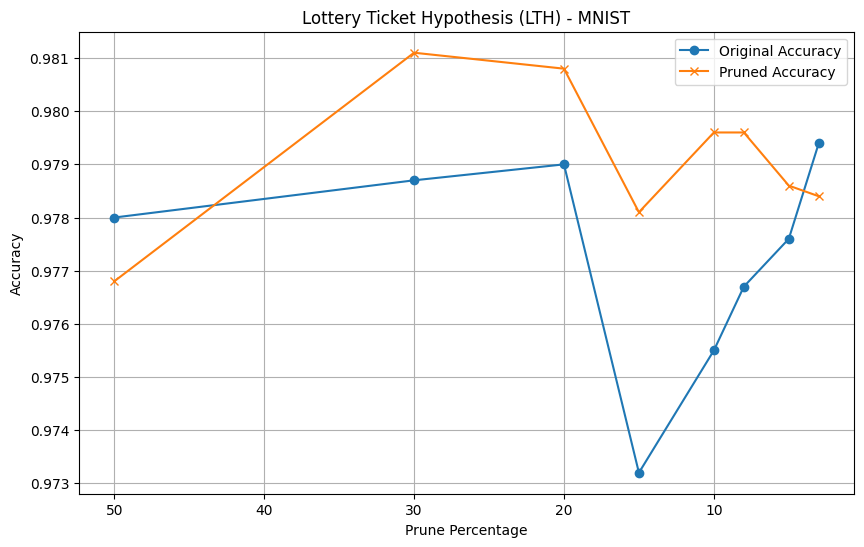

In [9]:
original_accuracies = [results[p]["accuracy_original"] for p in prune_percentages]
pruned_accuracies = [results[p]["accuracy_pruned"] for p in prune_percentages]

plt.figure(figsize=(10, 6))
plt.plot(prune_percentages, original_accuracies, label="Original Accuracy", marker="o")
plt.plot(prune_percentages, pruned_accuracies, label="Pruned Accuracy", marker="x")
plt.gca().invert_xaxis()  # Invertir eje X para visualizar mejor
plt.title("Lottery Ticket Hypothesis (LTH) - MNIST")
plt.xlabel("Prune Percentage")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()